In [4]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [2]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


#### 讀入資料以及單位化


In [5]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

## VAE model 設計

 <img src="HW0517.png" alt="drawing" style="width: 900px; height: 400px"/>

#### 將 Encoder 與 Decoder 中間的 Dense 層的神經元數目都改成 200。

In [6]:
enc_1 = Dense(200, activation='sigmoid')
# enc_2 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(200, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [7]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [10]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [11]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200)          157000      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            402         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            402         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [12]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

### 訓練 VAE

In [13]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [14]:
VAE.fit(x_train, x_train, batch_size=32, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 12s 205us/step - loss: 189.4438
Epoch 2/100
60000/60000 [==============================] - 11s 187us/step - loss: 180.2160
Epoch 3/100
60000/60000 [==============================] - 11s 185us/step - loss: 177.4482
Epoch 4/100
60000/60000 [==============================] - 11s 191us/step - loss: 173.3921
Epoch 5/100
60000/60000 [==============================] - 11s 186us/step - loss: 169.2757
Epoch 6/100
60000/60000 [==============================] - 11s 188us/step - loss: 166.2544
Epoch 7/100
60000/60000 [==============================] - 11s 190us/step - loss: 164.2392
Epoch 8/100
60000/60000 [==============================] - 11s 187us/step - loss: 162.6536
Epoch 9/100
60000/60000 [==============================] - 11s 189us/step - loss: 161.1750
Epoch 10/100
60000/60000 [==============================] - 11s 191us/step - loss: 159.6965
Epoch 11/100
60000/60000 [==============================] - 11s 187us/step - loss: 158.52

60000/60000 [==============================] - 11s 184us/step - loss: 142.0092
Epoch 90/100
60000/60000 [==============================] - 11s 188us/step - loss: 141.8983
Epoch 91/100
60000/60000 [==============================] - 11s 188us/step - loss: 141.8496
Epoch 92/100
60000/60000 [==============================] - 11s 187us/step - loss: 141.7822
Epoch 93/100
60000/60000 [==============================] - 11s 189us/step - loss: 141.7282
Epoch 94/100
60000/60000 [==============================] - 11s 187us/step - loss: 141.6687
Epoch 95/100
60000/60000 [==============================] - 11s 182us/step - loss: 141.7010
Epoch 96/100
60000/60000 [==============================] - 11s 186us/step - loss: 141.5896
Epoch 97/100
60000/60000 [==============================] - 11s 182us/step - loss: 141.5738
Epoch 98/100
60000/60000 [==============================] - 11s 181us/step - loss: 141.5477
Epoch 99/100
60000/60000 [==============================] - 11s 184us/step - loss: 141.4856
E

In [15]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 157,402
Trainable params: 157,402
Non-trainable params: 0
_________________________________________________________________


In [17]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               157584    
Total params: 158,184
Trainable params: 158,184
Non-trainable params: 0
_________________________________________________________________


### Encoder 視覺化

In [18]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 23879 圖的 latent 表示為 [[-0.20178139  0.18759054]]


In [20]:
indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

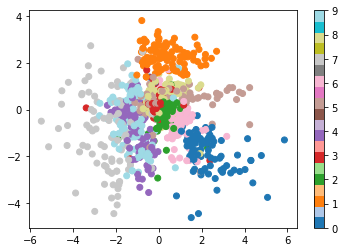

In [21]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

### 從圖看來 1與部分的7都有分的開

In [22]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [26]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

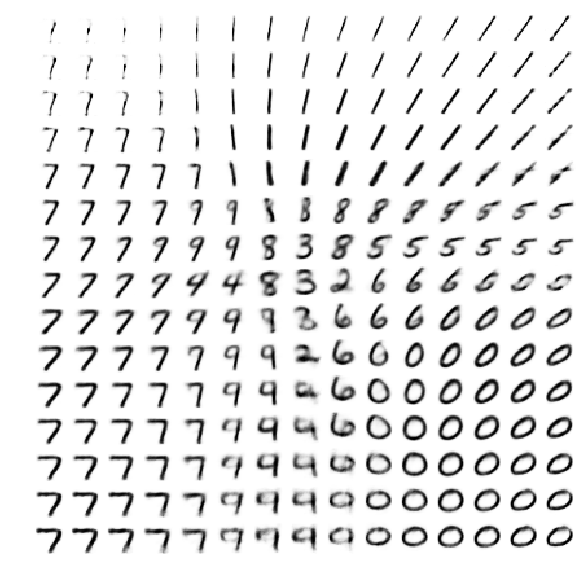

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

### 由左至右沒什麼改變，但由上至下逐漸能看出明顯的數字

### 動態比較

In [37]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='cool')
    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='summer')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='cool')

In [29]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]


#### 調整顏色：青-洋红、绿-黄、青-洋红

<function __main__.inBetween>

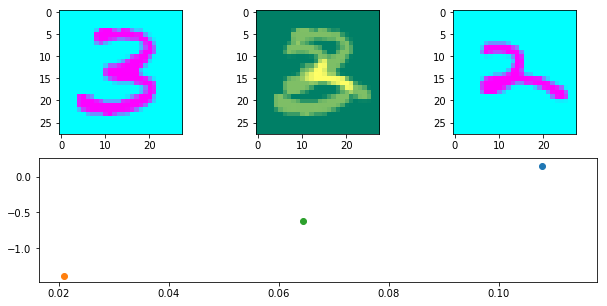

In [38]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

<img src="HW0517-2.png" alt="drawing" style="width: 900px; height: 400px"/>

### 結論

    將 Encoder 與 Decoder 的中間 Dense 層神經元數目改成 200。從視覺化發現：
    1. Encoder 降維後的區分能力還是只能明顯把兩個數字分開，其餘都混在一起
    2. Decoder 還原後由上至下逐漸能看出明顯的數字
    
    最後動態呈現讓顏色不同，使呈現的感覺更生動
    
    p.s. 我的滑桿一直無法顯示出來，我找了很久還是找不到原因